In [102]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [66]:
sns.set(rc={'figure.figsize':(10,5)})

In [2]:
CENSUS_PATH = 'data/refined/census_data.parquet'

CUSTOMER_PATH = 'data/refined/customer_data.parquet'

In [160]:
census = pd.read_parquet(CENSUS_PATH)

In [161]:
census.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,KBA13_VORB_0,KBA13_HHZ,KBA13_SEG_GELAENDEWAGEN,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET
0,910215,8.287263,0.040647,1.727637,0.004162,619.701439,1993.277011,0,0,0,...,3.0,3.0,3.0,6.0,6.0,5.0,4.0,3.0,1.0,1.0
1,910220,11.000000,0.000000,2.000000,0.000000,963.000000,1992.000000,0,0,0,...,3.0,5.0,2.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0
2,910225,10.000000,0.000000,1.000000,0.000000,712.000000,1992.000000,0,0,0,...,3.0,4.0,5.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0
3,910226,1.000000,0.000000,0.000000,0.000000,596.000000,1997.000000,0,0,0,...,4.0,3.0,3.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0
4,910241,3.000000,0.000000,4.000000,0.000000,435.000000,1992.000000,1,2,0,...,4.0,3.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0


In [162]:
census_var_types = pd.read_csv('data/trusted/census_var_types.csv').drop(columns='Unnamed: 0')

In [163]:
census_var_types.head()

,Attribute,Type
0,ALTERSKATEGORIE_GROB,interval
1,ALTER_HH,interval
2,ANREDE_KZ,binary
3,ANZ_HAUSHALTE_AKTIV,numeric
4,ANZ_HH_TITEL,numeric


In [164]:
census_var_types['Type'].value_counts()

interval    167
nominal      14
numeric       8
binary        5
Name: Type, dtype: int64

Variables considered as interval could be used in PCA. Unfortunately, this approach is not enough to handle nominal and binary features. An alteranitve approach to solve this problem is [Factorial Analysis of Mixed Data (FAMD)](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210).  
Using this approach, we will reduce the dimensions of Data prior to clustering it. It builds on top of sklearn's `TransformerMixIn` , so the implementation will be pretty straightfoward. 

# Clustering demographic data

## Adjustments to nominals and binaries

In [165]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

In [166]:
for col in binary_vars:

    print(col, census[col].unique())

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
OST_WEST_KZ [1. 0.]
VERS_TYP [2. 1.]
SOHO_KZ [0. 1.]


In [167]:
census['ANREDE_KZ'] = census['ANREDE_KZ'] - 1

census['VERS_TYP'] = census['VERS_TYP'] - 1

In [168]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

In [169]:
nominal_vars

array(['CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP',
       'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP',
       'KBA05_MAXHERST', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'STRUKTURTYP'],
      dtype=object)

In [170]:
census = pd.get_dummies(census, columns=nominal_vars)

In [171]:
dummy_nominal_vars = []

for name in nominal_vars:

    for col in census.columns:

        if name in col:

            dummy_nominal_vars.append(col)

# Fix for GEBAEUDETYP and GEBAUDETYP_RASTER
dummy_nominal_vars = sorted(list(set(dummy_nominal_vars)))

In [172]:
def weight_encoded_col(col):

    # mean = probability of occurance for a binary col
    mean = col.mean()

    weight = np.sqrt(mean)

    col = (col / weight) - mean
    
    # Centering
    center_ref = col.mean()

    col = col - center_ref
    
    return col

In [132]:
for col in list(binary_vars) + list(dummy_nominal_vars):

    census[col] = weight_encoded_col(census[col])

## Numerical columns

In [173]:
num_col_list = census.columns.drop(list(binary_vars) + dummy_nominal_vars + ['LNR'])

In [174]:
scaler = StandardScaler()

In [175]:
census[num_col_list] = scaler.fit_transform(census[num_col_list])

# PCA

In [152]:
comp_range = range(10,120,10)

In [68]:
explained_var_list = []

for comp in range(10,120, 10):

    print(f'Running for {comp} components...')
    pca = PCA(n_components=comp, random_state=123)

    pca.fit(census.drop(columns = 'LNR'))

    expl_variance = pca.explained_variance_ratio_.sum()

    print(f'Explained Variance: {expl_variance}')
    
    explained_var_list.append(expl_variance)

Running for 10 components...
Explained Variance: 0.3329549247682982
Running for 20 components...
Explained Variance: 0.4407196988382206
Running for 30 components...
Explained Variance: 0.5100926743553953
Running for 40 components...
Explained Variance: 0.5635581773771263
Running for 50 components...
Explained Variance: 0.6098664859246127
Running for 60 components...
Explained Variance: 0.6528997067897863
Running for 70 components...
Explained Variance: 0.6927238250236533
Running for 80 components...
Explained Variance: 0.7313262849332327
Running for 90 components...
Explained Variance: 0.7679039478030857
Running for 100 components...
Explained Variance: 0.8023333682623003
Running for 110 components...
Explained Variance: 0.8339299759860345


In [153]:
explained_var_list_step_2 = []

for comp in range(120,200, 20):

    print(f'Running for {comp} components...')
    pca = PCA(n_components=comp, random_state=123)

    pca.fit(census.drop(columns = 'LNR'))

    expl_variance = pca.explained_variance_ratio_.sum()

    print(f'Explained Variance: {expl_variance}')
    
    explained_var_list.append(explained_var_list_step_2)

Running for 120 components...
Explained Variance: 0.859781526484537
Running for 140 components...
Explained Variance: 0.9074555001751886
Running for 160 components...
Explained Variance: 0.9423711376640285
Running for 180 components...
Explained Variance: 0.9661005559717599


If we consider a threshold for 95% of variance, 180 components are the first amount of components that match this threshold

MONTAR PLOT DEPOIS

# K-Means

800k entries is too much for some machines to handle and/or take a long time for the algorithm to run.  
Therefore, assuming the AZDIAS data as the population we want to model for, we will use a sample of it to find the centroids of our clusters to then propagate this information.  
Using a simple [Sample Size Calculator](https://www.calculator.net/sample-size-calculator.html?type=1&cl=99.9&ci=1&pp=50&ps=891221&x=0&y=0), assuming a homogenous population, we find that for a confidence level of 99.9% and 1% margin of error, we can have approx. 26k points to model this population. 
To round up, we sample 30.000 points

In [110]:
def score_kmeans(X,k_range):

    for i, k in enumerate(k_range):

        print(f'Running for K = {k} Clusters...')

        # Using MiniBatch for performance
        kmeans = MiniBatchKMeans(n_clusters=k,
                                    init = 'k-means++',
                                    random_state=123,
                                    batch_size=2048,
                                    max_iter=50,
                                    n_init = 3)

        clusters = kmeans.fit_predict(X)

        score = silhouette_score(X, clusters)

        print(f'Silhouette score of: {score}', end = '\n\n')

        if i == 0:

            silhouette_list = [score]
        
        else:

            silhouette_list.append(score)

    return silhouette_list

In [154]:
X = pca.transform(census.drop(columns = 'LNR'))

In [155]:
# Offloading memory
del census

In [156]:
rng = np.random.default_rng()

# Reproducibility
np.random.seed = 123

X_sample = rng.choice(X, size = 30000, replace = False)

In [157]:
k_range = range(2,6)

In [158]:
sample_30k_silhouette = score_kmeans(X_sample, k_range)

Running for K = 2 Clusters...
Silhouette score of: 0.06474196033605022

Running for K = 3 Clusters...
Silhouette score of: 0.05339766298397601

Running for K = 4 Clusters...
Silhouette score of: 0.04063090921371187

Running for K = 5 Clusters...
Silhouette score of: 0.0330306754032392



In [92]:
for i, k in enumerate(k_range):

    print(f'Running for K = {k} Clusters...')

    # Using MiniBatch for performance
    kmeans = MiniBatchKMeans(n_clusters=k,
                                init = 'k-means++',
                                random_state=123,
                                batch_size=2048,
                                max_iter=50,
                                n_init = 3)

    clusters = kmeans.fit_predict(X_sample)

    score = silhouette_score(X_sample, clusters)

    print(f'Silhouette score of: {score}', end = '\n\n')

    if i == 0:

        silhouette_list = [score]
    
    else:

        silhouette_list.append(score)

Running for K = 2 Clusters...
Silhouette score of: 0.06395817226549276

Running for K = 3 Clusters...
Silhouette score of: 0.04702968907123202

Running for K = 4 Clusters...
Silhouette score of: 0.036985504875285895

Running for K = 5 Clusters...
Silhouette score of: 0.042770758409021406

Running for K = 6 Clusters...
Silhouette score of: 0.02250999771998223

Running for K = 7 Clusters...
Silhouette score of: -0.007969501755134679

Running for K = 8 Clusters...
Silhouette score of: -0.015460733694349568

Running for K = 9 Clusters...
Silhouette score of: -0.025490453709149256

Running for K = 10 Clusters...
Silhouette score of: -0.01028427739921058

Running for K = 11 Clusters...
Silhouette score of: -0.007315642448827877

Running for K = 12 Clusters...
Silhouette score of: -0.006361906995516497

Running for K = 13 Clusters...
Silhouette score of: -0.004087184113442582

Running for K = 14 Clusters...
Silhouette score of: -0.007402079612865776

Running for K = 15 Clusters...
Silhouette 

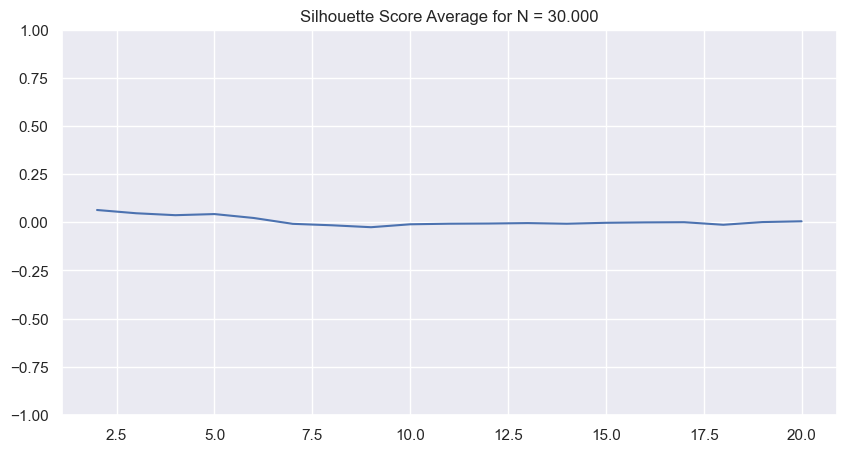

In [108]:
g = sns.lineplot(x = k_range, y = sample_30k_silhouette)

g.set(ylim = (-1,1))

plt.title('Silhouette Score Average for N = 30.000')

plt.show()

The plot clearly shows overlapping clusters (Score = 0). We can try to increase information to the algorithm by providing more data to it, i.e. increase sample size

In [111]:
X_sample = rng.choice(X, size = 50000, replace = False)

In [112]:
sample_50k_silhouette = score_kmeans(X_sample,k_range)

Running for K = 2 Clusters...
Silhouette score of: 0.06284699991256591

Running for K = 3 Clusters...
Silhouette score of: 0.04475893699842627

Running for K = 4 Clusters...
Silhouette score of: 0.02804108009105736

Running for K = 5 Clusters...
Silhouette score of: -0.028459711216973736

Running for K = 6 Clusters...
Silhouette score of: 0.012697826207335111

Running for K = 7 Clusters...
Silhouette score of: -0.021756046218411013

Running for K = 8 Clusters...
Silhouette score of: -0.010585970993355813

Running for K = 9 Clusters...
Silhouette score of: -0.010919694714641158

Running for K = 10 Clusters...
Silhouette score of: -0.009365197394872805

Running for K = 11 Clusters...
Silhouette score of: -0.007173869371622293

Running for K = 12 Clusters...
Silhouette score of: -0.004822670187907108

Running for K = 13 Clusters...
Silhouette score of: -0.05896160204795633

Running for K = 14 Clusters...
Silhouette score of: 0.0001178135796899852

Running for K = 15 Clusters...
Silhouette

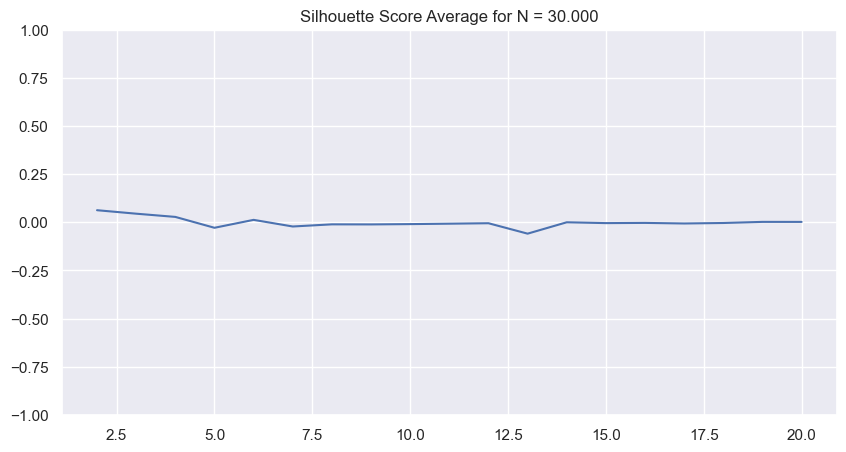

In [113]:
g = sns.lineplot(x = k_range, y = sample_50k_silhouette)

g.set(ylim = (-1,1))

plt.title('Silhouette Score Average for N = 30.000')

plt.show()

Even with more data the clustering doesn't show good results. Further/ Different preprocessing is required.

# PCA + K-Means - Second Approach
Using only interval and numeric Data

In [177]:
explained_var_list_step_2 = []

for comp in range(100,200, 20):

    print(f'Running for {comp} components...')
    pca = PCA(n_components=comp, random_state=123)

    pca.fit(census[num_col_list])

    expl_variance = pca.explained_variance_ratio_.sum()

    print(f'Explained Variance: {expl_variance}')
    
    explained_var_list.append(explained_var_list_step_2)

Running for 100 components...
Explained Variance: 0.927116116749541
Running for 120 components...
Explained Variance: 0.9595880784426121
Running for 140 components...
Explained Variance: 0.9821781176916982
Running for 160 components...
Explained Variance: 0.9959858334215564
Running for 180 components...


KeyboardInterrupt: 

In [178]:
pca = PCA(n_components=120, random_state=123)

X = pca.fit_transform(census[num_col_list])

In [181]:
X_sample = rng.choice(X, size = 30000, replace = False)

In [183]:
sample_30k_silhouette = score_kmeans(X_sample,k_range)

Running for K = 2 Clusters...
Silhouette score of: 0.07886697445769733

Running for K = 3 Clusters...
Silhouette score of: 0.06523842728456439

Running for K = 4 Clusters...
Silhouette score of: 0.058429719864345156

Running for K = 5 Clusters...
Silhouette score of: 0.04430354708615158



Pipeline:

**No completo**
- KNN Imputer
- FAMD (biblioteca prince)
- K-Means (ou batch)

**No customer**
- FAMD - **TREINADO NO COMPLETO**
- K-Means.predict()
- Analisar colunas